## Evaluate TF Lite model on test images

In [5]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pathlib

#If multiple GPU, set which GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [52]:
testdf = pd.read_csv('../data/SedMLdataTest.csv')
test_data_dir = '../data/CropPicsTest'
testdf = testdf.reset_index()  # make sure indexes pair with number of rows
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,0,F7crop21.jpg,0.086,0.103,0.118,0.133,0.154,0.220,0.526,1.143,2.593,4.717,4.763,0.568,1.273
1,1,F7crop22.jpg,0.170,0.189,0.207,0.224,0.245,0.299,0.364,0.398,0.430,0.474,0.529,0.001,0.955
2,2,F7crop23.jpg,0.145,0.170,0.195,0.217,0.245,0.325,0.456,0.558,0.677,0.810,0.991,0.154,1.029
3,3,F7crop24.jpg,0.169,0.193,0.217,0.241,0.272,0.354,0.468,0.557,0.681,0.870,1.074,0.138,1.134
4,4,F7crop25.jpg,0.148,0.164,0.179,0.191,0.205,0.240,0.281,0.304,0.326,0.357,0.396,0.025,1.011


In [8]:
#Load QAT model into TFlite intepreter
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_model_file = tflite_models_dir/"SandCam_QAT_notdense.tflite"
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.17 0.18899999999999997 0.207 0.22399999999999998 0.245 0.299 0.364
 0.39799999999999996 0.43 0.474 0.529]
Predicted Stats: [[0.13664001 0.19553909 0.21423297 0.25725985 0.2723121  0.36390993
  0.5579866  0.71162593 0.8408924  1.1046745  1.3383865 ]]


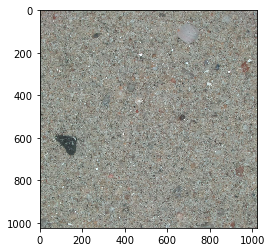

In [44]:
#Sanity check on a single image 
pix_dim = 1024
imsize = (pix_dim, pix_dim) 

#SET THE IMAGE
imgp = "../data/CropPicsTest/F7crop21.jpg"
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
test_image = np.expand_dims(img,axis=0)

#set up tensors and rpedict
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

#show results
plt.imshow(img)

print('Stats :', testdf.iloc[1,1:12].values )
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [45]:
#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot


In [46]:
# fn to do tflite prediction
def TFLitePred (imgpath):
    pix_dim = 1024
    imsize = (pix_dim, pix_dim) 
    #SET THE IMAGE
    img = tf.keras.preprocessing.image.load_img(imgpath,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_image = np.expand_dims(img,axis=0)

    #set up tensors and rpedict
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictionsQAT = interpreter.get_tensor(output_index)
    
    return predictionsQAT
    

In [64]:
#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in testdf.iterrows():
    imgpath = "../data/CropPicsTest/" + row['CropName']
    pred = TFLitePred (imgpath).flatten()
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["pD2mm", "pD5mm", "pD10mm", "pD16mm",
"pD25mm","pD50mm", "pD75mm", "pD84mm", "pD90mm",
"pD95mm", "pD98mm"]
predictions.head()

testdf = testdf.join(predictions)

testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD5mm,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm
0,0,F7crop21.jpg,0.086,0.103,0.118,0.133,0.154,0.220,0.526,1.143,...,0.195539,0.214233,0.257260,0.272312,0.363910,0.557987,0.711626,0.840892,1.104674,1.338387
1,1,F7crop22.jpg,0.170,0.189,0.207,0.224,0.245,0.299,0.364,0.398,...,0.203388,0.247563,0.242808,0.285726,0.388664,0.612349,0.787040,0.953161,1.210181,1.519309
2,2,F7crop23.jpg,0.145,0.170,0.195,0.217,0.245,0.325,0.456,0.558,...,0.171833,0.211847,0.265370,0.279104,0.409784,0.563534,0.712712,0.872627,1.137144,1.376505
3,3,F7crop24.jpg,0.169,0.193,0.217,0.241,0.272,0.354,0.468,0.557,...,0.199005,0.240904,0.255038,0.295620,0.448519,0.657155,0.870775,1.060537,1.321383,1.649189
4,4,F7crop25.jpg,0.148,0.164,0.179,0.191,0.205,0.240,0.281,0.304,...,0.206073,0.208477,0.237253,0.270974,0.336774,0.549694,0.705531,0.825352,1.087266,1.311215


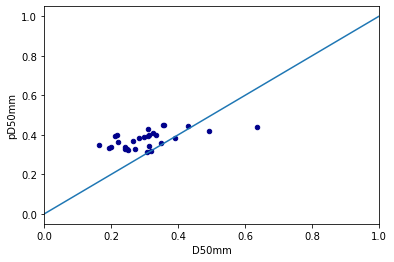

In [70]:
ax1 = testdf.plot.scatter(x='D50mm', y='pD50mm', c='DarkBlue')
L = pd.Series([0, 1])

ax1 = L.plot.line()

In [80]:
testdf.iloc[:,2:13].head()

,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm
0,0.086,0.103,0.118,0.133,0.154,0.220,0.526,1.143,2.593,4.717,4.763
1,0.170,0.189,0.207,0.224,0.245,0.299,0.364,0.398,0.430,0.474,0.529
2,0.145,0.170,0.195,0.217,0.245,0.325,0.456,0.558,0.677,0.810,0.991
3,0.169,0.193,0.217,0.241,0.272,0.354,0.468,0.557,0.681,0.870,1.074
4,0.148,0.164,0.179,0.191,0.205,0.240,0.281,0.304,0.326,0.357,0.396


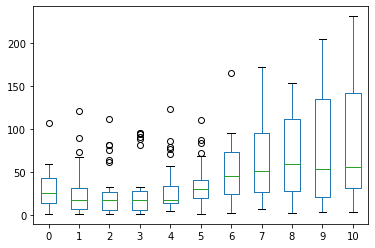

In [84]:
#plot of mean absolute percent error

error = pd.DataFrame(100*abs(testdf.iloc[:,2:13].values - predictions.values)/testdf.iloc[:,2:13].values)

ax = error.plot.box()